In [1]:
# prompt: googlemount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import sklearn
import math
import statistics
import warnings
import os

warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns',None)

In [3]:
temp_data=pd.read_csv(r"/content/drive/MyDrive/lending_club/Cleansing_data1_out_current_order_by_date.csv",low_memory=False,keep_default_na=True)

In [4]:
temp_data['target'] = temp_data['total_rec_prncp']/temp_data['funded_amnt']

In [ ]:
# temp_data = temp_data.dropna(subset=['target']) # 결측치행 제거

In [5]:
temp_data['target'].isna().sum()

0

In [6]:
# temp_data에서 랜덤으로 10000개 행 추출
temp_data = temp_data.sample(n=10000, random_state=42)

# 결과 확인
len(temp_data)

10000

In [10]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import numpy
import pandas
import random

# 목표 변수 설정
target_column = 'target'
# 우선은 object 타입의 열을 제외하고 숫자 데이터만 포함하는 새로운 데이터프레임 생성
temp_data = temp_data.select_dtypes(include=[numpy.number])


x = temp_data.drop(target_column, axis=1).values.astype(numpy.float32)
y = temp_data[target_column].values.astype(numpy.float32)


# 3. 데이터셋을 학습, 검증, 테스트로 나누기
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.30, random_state=101)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=101)


In [11]:
x

array([[ 8000.,  8000.,  8000., ...,     0.,     0.,     0.],
       [24000., 24000., 24000., ...,     0.,     0.,     0.],
       [30000., 30000., 30000., ...,     0.,     0.,     0.],
       ...,
       [ 6000.,  6000.,  6000., ...,     0.,     0.,     0.],
       [30000., 30000., 30000., ...,     0.,     0.,     0.],
       [ 6000.,  6000.,  6000., ...,     0.,     0.,     0.]],
      dtype=float32)

*  지금부터 GPU설정을 위해서 터미널을 실행시켜야함
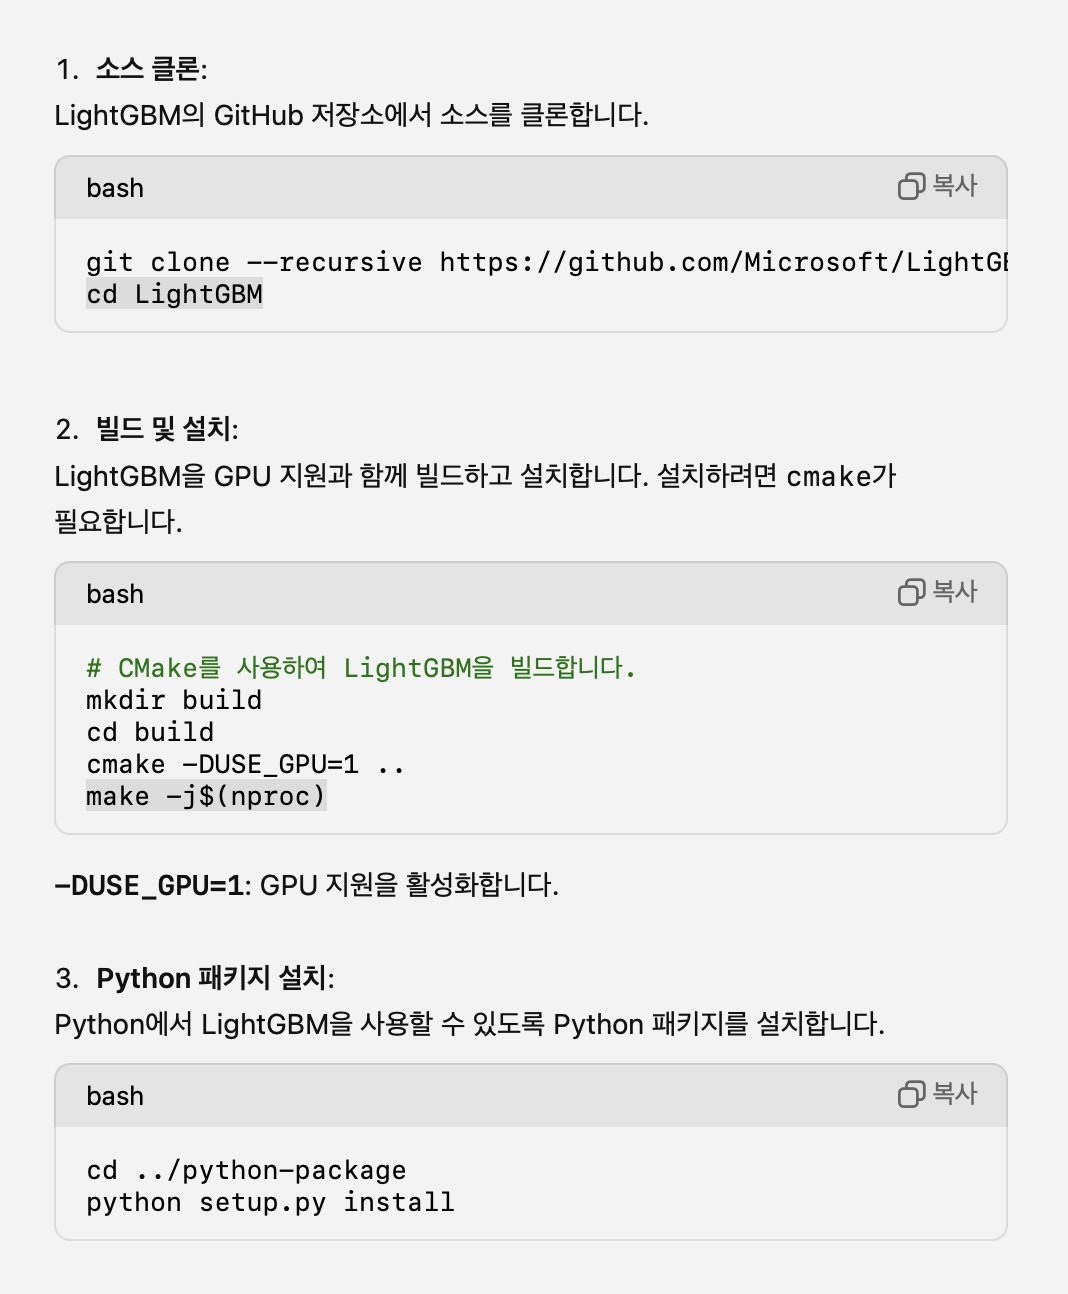

* 이렇게 해야 실행시킬 수 있음

* !bash # 코랩 터미널 실행시키는 코드

In [21]:
!bash

bash: cannot set terminal process group (952): Inappropriate ioctl for device
bash: no job control in this shell
/content# ls
drive  LightGBM  sample_data
/content# cd LightGBM
/content/LightGBM# cd python-package
/content/LightGBM/python-package# ls
lightgbm  pyproject.toml  README.rst  setup.cfg
/content/LightGBM/python-package# pip install .
Processing /content/LightGBM/python-package
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint:

> 로컬에서는 실행될것같음

위에만 되면 다됨

In [22]:
import lightgbm as lgb

# GPU 장치 사용 가능한지 확인
print("LightGBM version:", lgb.__version__)
print("Is GPU available?", lgb.__version__ == 'gpu')

LightGBM version: 4.4.0
Is GPU available? False


In [12]:
# 4. LightGBM 모델 설정 및 Randomized Search
params = {
    'objective': ['regression'],  # 회귀를 위한 설정
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'boosting_type': ['gbdt'],  # 기본 부스팅 유형
    'random_state': [101],
    'device_type': ['gpu']  # GPU 사용 설정
}

lgb_model = lgb.LGBMRegressor()
random_search = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=50, cv=3, verbose=1, random_state=101, n_jobs=-1)
random_search.fit(x_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


ValueError: 
All the 81 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1173, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 954, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 282, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 3631, in __init__
    _safe_call(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 294, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode("utf-8"))
lightgbm.basic.LightGBMError: No OpenCL device found


In [ ]:


# 최적의 파라미터와 모델 출력
print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_

# 5. 모델 성능 평가
y_pred_val = best_model.predict(x_val)
y_pred_test = best_model.predict(x_test)

print("Validation Set Performance:")
print(f"RMSE: {numpy.sqrt(mean_squared_error(y_val, y_pred_val))}")

print("Test Set Performance:")
print(f"RMSE: {numpy.sqrt(mean_squared_error(y_test, y_pred_test))}")

# 6. 새로운 데이터 포인트에 대한 예측
random.seed(101)
random_ind = random.randint(0, len(temp_data) - 1)
new_customer = temp_data.drop(target_column, axis=1).iloc[random_ind].values.reshape(1, -1)

predicted_return = best_model.predict(new_customer).item()

print(f"Model Prediction for new customer: {predicted_return}")
print(f"Actual return rate: {temp_data.iloc[random_ind][target_column]}")


Best parameters found:  {'tree_method': 'gpu_hist', 'random_state': 101, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1}
Validation Set Performance:
RMSE: 0.011664404533803463
Test Set Performance:
RMSE: 0.010372010059654713
Model Prediction for new customer: 1.0006046295166016
Actual return rate: 1.0
